In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import os
import time

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.model_selection as model_selection

import tensorflow as tf
from tensorflow import keras

import h5py

In [ ]:
# Set your own project id here
PROJECT_ID = 'your-google-cloud-project'
from google.cloud import storage
storage_client = storage.Client(project=PROJECT_ID)

In [2]:
TEST_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_test'))]
TRAIN_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_train'))]

In [3]:
def decode(serialized_example):
    feats = tf.io.parse_single_example(serialized_example, features={'x1': tf.io.FixedLenFeature([], tf.string),
                                                                     'x2': tf.io.FixedLenFeature([], tf.string),
                                                                     'x3': tf.io.FixedLenFeature([], tf.string),
                                                                     'y': tf.io.FixedLenFeature([], tf.string)})

    x1 = tf.io.decode_raw(feats['x1'], tf.float64)
    x1 = tf.reshape(x1, [32,37,32,424])
    
    x2 = tf.io.decode_raw(feats['x2'], tf.float64)
    x2.set_shape((1378))
    
    x3 = tf.io.decode_raw(feats['x3'], tf.float64)
    x3.set_shape((26))
    
    y = tf.io.decode_raw(feats['y'], tf.float64)
    y.set_shape((5))

    X = (x1, x2, x3)
    return X, y

In [4]:
def get_dataset(tfr_data, batch_size):
    ds = tf.data.TFRecordDataset(tfr_data, compression_type="GZIP")
    ds = ds.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     ds = ds.shuffle(buffer_size=4000, seed=30, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [5]:
batch_size = 8

tfr_train = 'train.tfrecord'
tfr_val = 'val.tfrecord'
tfr_test = 'test.tfrecord'

ds_train = get_dataset(tfr_train, batch_size)
ds_val = get_dataset(tfr_val, batch_size)
ds_test = get_dataset(tfr_test, batch_size)

In [7]:
INPUT_SHAPE_mri = (32,37,32,424)

In [8]:
INPUT_SHAPE_fnc = (1378,)

In [9]:
INPUT_SHAPE_loading = (26,)

In [10]:
def create_model(INPUT_SHAPE_mri, INPUT_SHAPE_fnc, INPUT_SHAPE_loading):
    #============================================================================
    # CNN for MRI images processing
    #============================================================================
    inputs_mri = keras.layers.Input(shape=INPUT_SHAPE_mri, name='inpupt_mri')

    # convolution block #1
    block_1 = keras.layers.Conv3D(256, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(inputs_mri)
    block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
    block_1 = keras.layers.Conv3D(256, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_1)
    block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
    block_1 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_1)
    block_1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_1)

    # convolution block #2
    block_2 = keras.layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_1)
    block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
    block_2 = keras.layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_2)
    block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
    block_2 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_2)
    block_2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_2)

    # convolution block #3
    block_3 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_2)
    block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
    block_3 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_3)
    block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
    block_3 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_3)
    block_3 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_3)

    # convolution block #4
    block_4 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_3)
    block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
    block_4 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_4)
    block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
    block_4 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_4)
    block_4 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_4)

    flatten = keras.layers.Flatten(data_format='channels_last')(block_4)

    # hidden layer
    x = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(flatten)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x)

    # output
    x = keras.Model(inputs=inputs_mri, outputs=x, name='model_mri')

    #============================================================================
    # MLP for FNC correlation features processing
    #============================================================================
    inputs_fnc = keras.layers.Input(shape=INPUT_SHAPE_fnc, name='input_fnc')

    y = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(inputs_fnc)
    y = keras.layers.Dense(2048,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)

    y1 = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y1)
    y1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(y1)

    y2 = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y2)
    y2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(y2)

    y = keras.layers.concatenate([y1, y2])

    y = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)

    # output
    y = keras.Model(inputs=inputs_fnc, outputs=y, name='model_fnc')

    #============================================================================
    # MLP for sMRI SBM loadings processing
    #============================================================================
    inputs_loading = keras.layers.Input(shape=INPUT_SHAPE_loading, name='input_load')

    z = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(inputs_loading)

    z = keras.layers.Dense(256,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)

    z1 = keras.layers.Dense(128,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z1)
    z1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(z1)

    z2 = keras.layers.Dense(128,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z2)
    z2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(z2)

    z = keras.layers.concatenate([z1, z2])

    z = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)

    # output
    z = keras.Model(inputs=inputs_loading, outputs=z, name='model_loading')

    
    concat0 = keras.layers.concatenate([y.output, z.output])
    concat0 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(concat0)

    concat0 = keras.layers.Dense(512, 
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(concat0)
    concat0 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(concat0)

    concat1 = keras.layers.concatenate([x.output, concat0])


    concat = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(concat1)
    concat = keras.layers.Dense(2048, 
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(concat)
    concat = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(concat)

    outputs = keras.layers.Dense(5, activation='linear')(concat)

    model = keras.Model(inputs=[x.input, y.input, z.input], outputs=outputs, name='model_combined')

    optim = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)

    METRICS = [keras.metrics.RootMeanSquaredError(name='rmse'),
               keras.metrics.MeanSquaredError(name='mse')]

    model.compile(loss='mae', metrics=METRICS, optimizer=optim)
    return model

In [11]:
model = create_model(INPUT_SHAPE_mri, INPUT_SHAPE_fnc, INPUT_SHAPE_loading)

In [12]:
model.summary()

Model: "model_combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpupt_mri (InputLayer)         [(None, 32, 37, 32,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 37, 32, 2 2930944     inpupt_mri[0][0]                 
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 32, 37, 32, 2 9699328     conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 37, 32, 2 1769728     p_re_lu[0][0]                    
_____________________________________________________________________________________

In [13]:
# checkpoint_dir = './99_Training_checkpoints/mri-fnc-loading'

In [14]:
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [15]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=10, 
                                              verbose=1, 
                                              mode='min',
                                              baseline=None, 
                                              restore_best_weights=True)]

In [16]:
# checkpoint_prefix = os.path.join('./99_Training_checkpoints/mri-fnc-loading', "ckpt_{epoch}")

# callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/mri-fnc-loading'),
#              tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
#                                                 save_weights_only=True),
#              tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                               min_delta=0.001, 
#                                               patience=10, 
#                                               verbose=1, 
#                                               mode='min',
#                                               baseline=None, 
#                                               restore_best_weights=True)]

In [17]:
with tf.device('/GPU:0'):
    hist = model.fit(ds_train,
                     validation_data=ds_val,
                     callbacks=callbacks,
                     epochs=1,
                     verbose=1)

470/470 [==============================] - 2155s 5s/step - loss: 40.0324 - rmse: 41.8706 - mse: 1753.1509 - mae: 40.0324 - val_loss: 35.0244 - val_rmse: 36.9756 - val_mse: 1367.1946 - val_mae: 35.0244


In [21]:
with tf.device('/GPU:0'):
    results = model.evaluate(ds_test, verbose=1)

147/147 [==============================] - 539s 4s/step - loss: 8.2603 - rmse: 10.7114 - mse: 114.7334 - mae: 8.2603TA: 6 - ETA: 2:39 - loss: 8.2356 - rmse: 10.6481 - mse:  - ETA: 1:18 - loss: 8.2310 - rmse: 1


Text(0.5, 1.0, 'Metric')

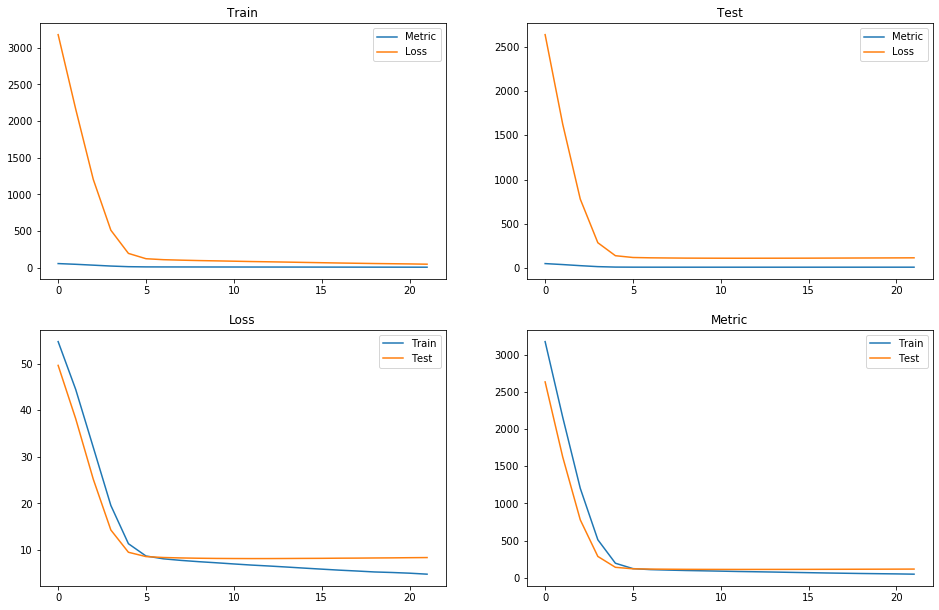

In [22]:
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_rmse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['mse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')

In [56]:
y_preds = []
for i in TEST_IDS:
    X_mri, X_fnc, X_loading = get_inputs_subm(i)
    X_mri = X_mri.reshape(1,32, 37, 32, 424)
    X_fnc = X_fnc.reshape(1,1378)
    X_loading = X_loading.reshape(1,26)
    preds = model.predict([X_mri, X_fnc, X_loading], batch_size=1)
    y_preds.append(preds)

In [57]:
len(y_preds)

5877

In [59]:
y_preds = np.array(y_preds).flatten()

In [60]:
df_submission = []
i = 0
for idx in TEST_IDS:
    df_submission.append(['{0}_age'.format(idx), y_preds[i]])
    df_submission.append(['{0}_domain1_var1'.format(idx), y_preds[i+1]])
    df_submission.append(['{0}_domain1_var2'.format(idx), y_preds[i+2]])
    df_submission.append(['{0}_domain2_var1'.format(idx), y_preds[i+3]])
    df_submission.append(['{0}_domain2_var2'.format(idx), y_preds[i+4]])
    i += 5

df_submission = pd.DataFrame(df_submission, columns=['Id', 'Predicted'])

In [61]:
df_submission.to_csv('submission_mri-fnc-load_mae_00.csv', index=False)